## Imports

In [ ]:
# !pip3 install https://huggingface.co/d4data/en_pipeline/resolve/main/en_pipeline-any-py3-none-any.whl


In [1]:
!pip install transformers==4.35.1
import transformers
transformers.__version__

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.15.0 requires huggingface-hub>=0.18.0, but you have huggingface-hub 0.17.3 which is incompatible.
spacy-transformers 1.1.7 requires transformers<4.21.0,>=3.4.0, but you have transformers 4.35.1 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Yeshwanth Somu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


     ---------------------------------------- 7.9/7.9 MB 25.4 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 46.5 MB/s eta 0:00:00
     ---------------------------------------- 295.0/295.0 kB ? eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1


'4.35.1'

In [2]:
import pandas as pd
import numpy as np
import os
import subprocess
# from Dbias.bias_classification import *

from pprint import pprint
# from transformers import T5Tokenizer, TFT5ForConditionalGeneration

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from transformers import BertTokenizer, TFBertModel
import random

np.random.seed(1)


## Aggregating all bias datasets together

In [3]:
file_bias_map = {"cognitive-bias.csv":"Cognitive Bias", "fake-news.csv": "Fake News", "gender-bias.csv": "Gender Bias", "hate-speech.csv": "Hate Speech",
                "linguistic-bias.csv": "Linguistic Bias", "political-bias.csv": "Political Bias", "racial-bias.csv": "Racial Bias", "text-level-bias.csv": "Text Level Bias"}

full_data = []
for i in os.listdir("datasets/mbib-aggregated/"):
    data = pd.read_csv("datasets/mbib-aggregated/"+i)
    data['bias_type'] = file_bias_map[i]
    full_data.append(data)

full_data = pd.concat(full_data)
full_data.loc[~full_data.label.astype(bool), "bias_type"] = "Unbiased" # converting all non-labeled pieces of text to "Unbiased"

full_data = full_data.reset_index().drop(columns="index")

full_data["biased"] = full_data["bias_type"] != "Unbiased"
full_data.head()

,id,text,label,dataset_id,bias_type,biased
0,072-9268,To vote in Mexico every eligible Mexican citiz...,0,72,Unbiased,False
1,072-6808,Marco Rubio made it clear Not only does he thi...,0,72,Unbiased,False
2,072-5150,Ben Carson is running for president to elimina...,0,72,Unbiased,False
3,072-11817,There are literally teachers now who are getti...,0,72,Unbiased,False
4,072-7176,Leticia Van de Putte voted to stop schools fro...,0,72,Unbiased,False


## EDA

In [4]:
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 20})

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
#           '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# plt.figure(figsize=(25,12))
# ax = full_data.bias_type.value_counts().plot(kind="bar", title="Article Distribution by Bias", color=colors, ylabel="Count", xlabel="Type of Bias")
# ax.bar_label(ax.containers[0], label_type='edge')
# plt.tight_layout()

## BERT Model for Multi-class classification

### Data Processing and Cleaning

In [5]:
full_data.shape, full_data.bias_type.value_counts()

((496942, 6),
 Unbiased           248471
 Linguistic Bias    200931
 Hate Speech         12498
 Gender Bias          8970
 Political Bias       8852
 Racial Bias          4894
 Text Level Bias      4509
 Fake News            4271
 Cognitive Bias       3546
 Name: bias_type, dtype: int64)

In [6]:
### Data Characteristics
## 496,942 total pieces of text

full_data = full_data[~full_data["text"].isnull()] # only one row without any text

## Removing unnecessary capitalized keywords
for keyword in ["MENTION", "MKR", "SD", "BREAKING", "RT", 'mkr', "NEWS"]:
  full_data['text'] = full_data['text'].apply(lambda x: ' '.join([w for w in x.split() if not keyword in w]))

## Replacing occurrences of words such as "you re" or "can t" where the apostrophe isn't present
mapping = {
    ' ve ': "'ve ",
    ' re ': "'re ",
    ' m ': "'m ",
    ' t ': "'t "
}
def replace_words(text):
  for key, value in mapping.items():
    text = text.replace(key, value)
  return text
full_data['text'] = full_data['text'].apply(replace_words)
full_data

#Added word count column
full_data['article_wd_ct'] = full_data['text'].str.split().str.len() ## word count of each article

(<Axes: >,
 count    496941.000000
 mean         43.258735
 std          63.916930
 min           0.000000
 25%          17.000000
 50%          25.000000
 75%          37.000000
 max        2307.000000
 Name: article_wd_ct, dtype: float64)

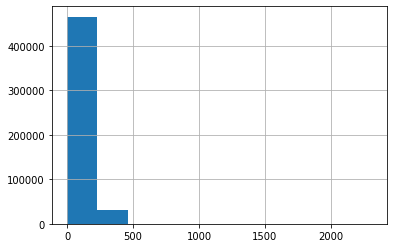

In [7]:
# Word Count Distribution
full_data["article_wd_ct"].hist(), full_data["article_wd_ct"].describe()


In [8]:
# Removing texts less than 5 words long since they generally aren't coherent and are only 2% of the overall data
# print(f'About {round(full_data[full_data["article_wd_ct"]<=5].shape[0]/full_data.shape[0]*100)}% of the entries are less than or equal to 5 words')
full_data = full_data[full_data["article_wd_ct"]>5]

## Every text is basically under 500 words with 0.05% of the texts being above
# print(f'About {round(full_data[full_data["article_wd_ct"]>500].shape[0]/full_data.shape[0]*100, 3)}% of the entries are less than or equal to 5 words')
full_data = full_data[full_data["article_wd_ct"]<=500]

full_data = full_data.reset_index()



### Model Setup

In [9]:
full_data.bias_type.value_counts()

Unbiased           243588
Linguistic Bias    199485
Hate Speech         11931
Gender Bias          8635
Political Bias       8284
Racial Bias          4687
Fake News            4197
Text Level Bias      3943
Cognitive Bias       3478
Name: bias_type, dtype: int64

In [10]:
## Subsetting data to specific bias types
# removing Cognitive Bias should help make Fake News' perfomance better
final_bias_list = ["Unbiased", "Political Bias", "Gender Bias", "Racial Bias", "Fake News", "Hate Speech", "Linguistic Bias"]

full_data = full_data[full_data.bias_type.isin(final_bias_list)]

In [11]:
## Sampling equal amount of texts from each bias type for equal training and testing sizes
sample_size = 3000
sample = full_data.groupby("bias_type").apply(lambda x: x.sample(sample_size, random_state=1)).reset_index(drop=True)
sample.bias_type.value_counts()


Fake News          3000
Gender Bias        3000
Hate Speech        3000
Linguistic Bias    3000
Political Bias     3000
Racial Bias        3000
Unbiased           3000
Name: bias_type, dtype: int64

In [12]:
## Assigning numerical label to publication
bias_mapping = {j:i for i, j in enumerate(sample.bias_type.unique())}
sample["bias_type_id"] = sample["bias_type"]
sample = sample.replace({"bias_type_id":bias_mapping})

sample = sample.reset_index()


In [13]:
sample.head()

,level_0,index,id,text,label,dataset_id,bias_type,biased,article_wd_ct,bias_type_id
0,0,13125,072-4980,In three days last week Gov Rick Perry flew to...,1,72,Fake News,True,24,0
1,1,12154,072-7698,Dolphins are rapists Look it up,1,72,Fake News,True,6,0
2,2,13604,072-6501,For every 33 pregnant women that walk into a P...,1,72,Fake News,True,16,0
3,3,12595,072-2167,Tampa is the strip club capital of the world,1,72,Fake News,True,9,0
4,4,12384,072-6946,Quotes Mark Cuban as saying I worry that milli...,1,72,Fake News,True,21,0


In [21]:
def convert_to_lists(data, text_col, label_id_col, label_col, test_size=0.2):
  texts = data[text_col].values
  labels = data[label_id_col].values
  label_names = list(data[label_col].unique())
  return train_test_split(texts, labels, test_size=test_size, random_state=1), label_names

(train_texts, test_texts, train_labels, test_labels), label_names = convert_to_lists(data=sample, text_col="text", label_id_col="bias_type_id", label_col="bias_type")
len(train_texts), len(test_texts), len(train_labels), len(test_labels), len(label_names)


(16800, 4200, 16800, 4200, 7)

In [22]:
num = 15000
valid_texts = train_texts[num:]
valid_labels = train_labels[num:]
train_texts = train_texts[:num]
train_labels = train_labels[:num]

#get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

train_texts = list(train_texts)
valid_texts = list(valid_texts)
test_texts = list(test_texts)


In [37]:
# Setting up BERT model
model_checkpoint = 'bert-base-cased'
max_length = 400

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [49]:
## Separating the encodings
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, return_tensors='tf')

##################################################################################################################################################################

zeros_arr = np.zeros((test_encodings.input_ids.numpy().shape[0], max_length-test_encodings.input_ids.numpy().shape[1]))
test_encodings.input_ids = np.hstack((test_encodings.input_ids.numpy(), zeros_arr))

zeros_arr = np.zeros((test_encodings.token_type_ids.numpy().shape[0], max_length-test_encodings.token_type_ids.numpy().shape[1]))
test_encodings.token_type_ids = np.hstack((test_encodings.token_type_ids.numpy(), zeros_arr))

zeros_arr = np.zeros((test_encodings.attention_mask.numpy().shape[0], max_length-test_encodings.attention_mask.numpy().shape[1]))
test_encodings.attention_mask = np.hstack((test_encodings.attention_mask.numpy(), zeros_arr))

In [51]:
def create_bert_multiclass_model(learning_rate,
                                 checkpoint = model_checkpoint,
                                 MAX_SEQUENCE_LENGTH = max_length,
                                 num_classes = 12,
                                 hidden_size = max_length+1,
                                 dropout=0.3):
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    # input_ids = np.ones(shape=(MAX_SEQUENCE_LENGTH, 1), dtype=np.int64)  # Create a placeholder tensor
    # token_type_ids = np.ones(shape=(MAX_SEQUENCE_LENGTH, 1), dtype=np.int64)  # Create a placeholder tensor
    # attention_mask = np.ones(shape=(MAX_SEQUENCE_LENGTH, 1), dtype=np.int64)  # Create a placeholder tensor
    # print(type(input_ids))

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss="sparse_categorical_crossentropy",
                                 metrics='accuracy')

    return classification_model

In [52]:
def train_and_test_bert_model(learning_rate):
  pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes = len(label_names), learning_rate=learning_rate)
  print(f'Starting training of BERT model with learning rate {learning_rate}')
  pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                    train_labels,
                                                    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                    npvalid_labels),
                                                    batch_size=8,
                                                    epochs=1)

  score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
  predictions_model1 = tf.argmax(predictions_model1, axis=-1)

  # print(classification_report(test_labels, predictions_model1.numpy(), target_names=label_names))
  cm = tf.math.confusion_matrix(test_labels, predictions_model1)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(20,7))
  sns.heatmap(
      cm, annot=True,
      xticklabels=label_names,
      yticklabels=label_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  return pooler_bert_model

In [ ]:
## LR = 0.00001 with subset of bias labels
model2 = train_and_test_bert_model(learning_rate=0.00001)

### Initial Results w all Labels

In [ ]:
## LR = 0.00001 w all classes
%time
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes = len(label_names), learning_rate=0.00001)
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.63 µs
2500/2500 [==============================] - 2401s 947ms/step - loss: 0.9382 - accuracy: 0.5740 - val_loss: 0.8537 - val_accuracy: 0.5913


In [ ]:
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

169/169 [==============================] - 199s 1s/step - loss: 0.8789 - accuracy: 0.5824
Test loss: 0.8788508176803589
Test accuracy: 0.5824074149131775


In [ ]:
predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions_model1 = tf.argmax(predictions_model1, axis=-1)

# print(classification_report(test_labels, predictions_model1.numpy(), target_names=label_names))
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

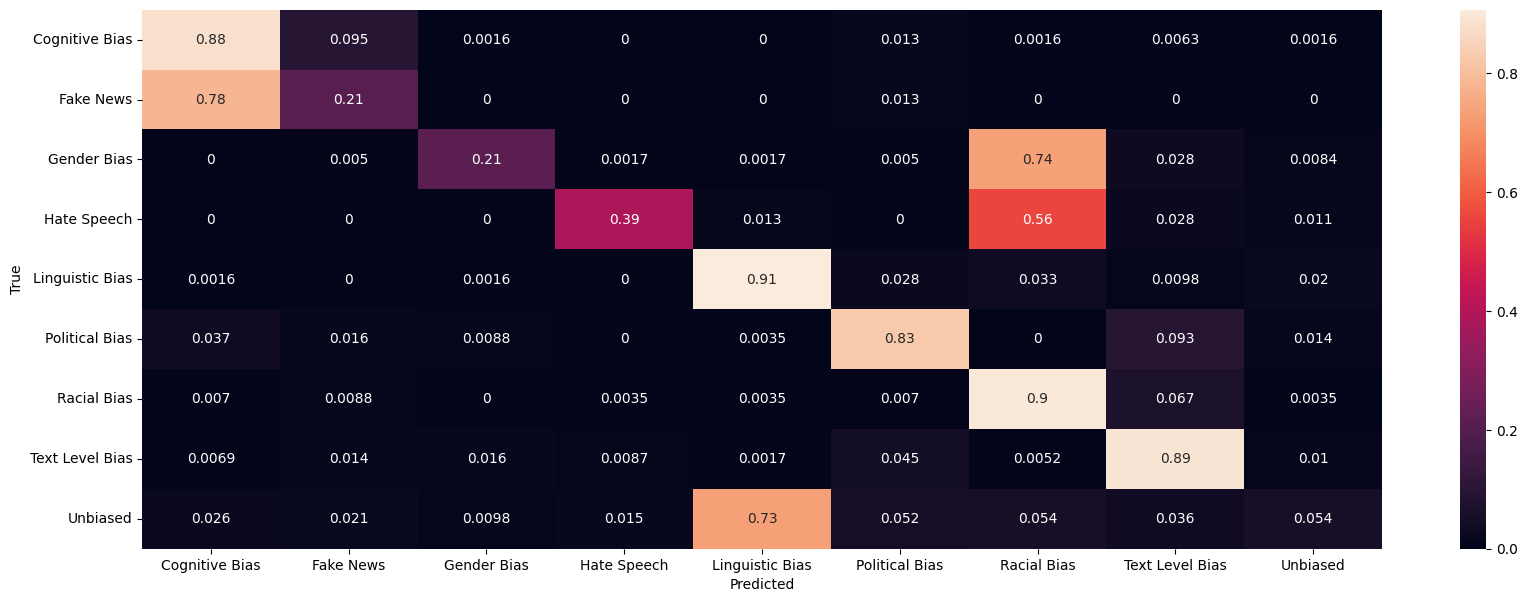

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=label_names,
    yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
## LR = 0.00008 w all classes
%time
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes = len(label_names), learning_rate=0.00008)
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
2500/2500 [==============================] - 2400s 946ms/step - loss: 1.1797 - accuracy: 0.4972 - val_loss: 0.9818 - val_accuracy: 0.5575


## Dbias Binary Classification (NO NEED to run this for running BERT Model)

In [ ]:
import sys
def bias_classifier(x):
    try:
        return classifier(x)
    except:
        return [{"label":"Error"}]

def repeat_classifier_on_subset(full_data = full_data, size=.2):

    # getting sample of full_data with representative proportions of the "biased" column
    sample_size = size * len(full_data)  # 30% of the original dataset size
    mini = full_data.groupby("biased").sample(int(sample_size / 2), replace=True)

    # running the bias_classifier() on text in this sample, since it takes 500+ mins to run on the entire full_data df
    mini["output"] = mini["text"].agg(lambda x: bias_classifier(x))
    mini["pred_label"] = mini["output"].apply(lambda x: x[0]["label"])
    # mini["pred_score"] = mini["output"].apply(lambda x: x[0]["score"])
    mini["pred_label"] = mini["pred_label"] == "Biased"
    conf_matrix = pd.crosstab(mini["pred_label"], mini["biased"])

    return mini, conf_matrix

In [ ]:
sample_size = .2 * len(full_data)
mini = full_data.groupby("biased").sample(int(sample_size / 2), replace=True)

# running the bias_classifier() on text in this sample, since it takes 500+ mins to run on the entire full_data df
mini["output"] = mini["text"].agg(lambda x: bias_classifier(x))
mini["pred_label"] = mini["output"].apply(lambda x: x[0]["label"])
# mini["pred_score"] = mini["output"].apply(lambda x: x[0]["score"])
mini["pred_label"] = mini["pred_label"] == "Biased"
conf_matrix = pd.crosstab(mini["pred_label"], mini["biased"])

In [ ]:
conf_matrix

biased,False,True
pred_label,,
False,49694,49694


In [ ]:
pd.crosstab(mini["pred_label"], mini["biased"], normalize="index")

biased,False,True
pred_label,,
False,0.5,0.5


In [ ]:
%%time
sample_size = .2 * len(full_data)
mini2 = full_data.groupby("biased").sample(int(sample_size / 2), replace=True)

# running the bias_classifier() on text in this sample, since it takes 500+ mins to run on the entire full_data df
mini2["output"] = mini2["text"].agg(lambda x: bias_classifier(x))
mini2["pred_label"] = mini2["output"].apply(lambda x: x[0]["label"])
mini2["pred_label"] = mini2["pred_label"] == "Biased"
conf_matrix2 = pd.crosstab(mini2["pred_label"], mini2["biased"])
conf_matrix2

CPU times: user 507 ms, sys: 16.2 ms, total: 523 ms
Wall time: 518 ms


biased,False,True
pred_label,,
False,49694,49694


In [ ]:
pd.crosstab(mini2["pred_label"], mini2["biased"], normalize="index")

biased,False,True
pred_label,,
False,0.5,0.5
